In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

train_data = pd.read_csv('./generated_data/train_data.csv')
valid_data = pd.read_csv('./generated_data/validation_data.csv')
test_data = pd.read_csv('./generated_data/test_data.csv')

X_train, y_train = train_data.drop(columns=['Class']), train_data['Class']
X_valid, y_valid = valid_data.drop(columns=['Class']), valid_data['Class']
X_test, y_test = test_data.drop(columns=['Class']), test_data['Class']

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_valid, y_valid = shuffle(X_valid, y_valid, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


In [ ]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(random_state=42)
model.fit(X_train)

IsolationForest(random_state=42)

Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.96      0.91       360
     Anomaly       0.96      0.84      0.90       360

    accuracy                           0.90       720
   macro avg       0.91      0.90      0.90       720
weighted avg       0.91      0.90      0.90       720

False Positive Rate: 0.04
False Negative Rate: 0.16


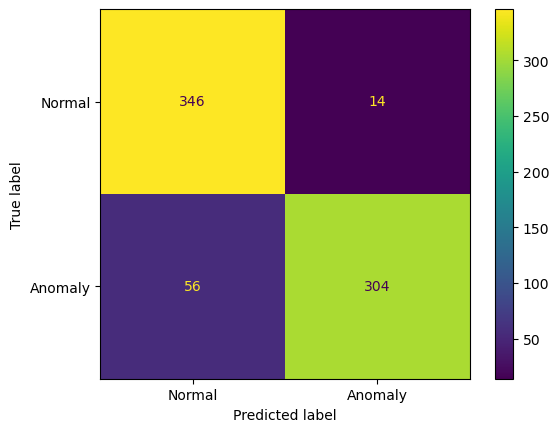

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred = np.where(y_pred == 1, 0, 1)  # 1: 정상 -> 0으로, -1: 이상 -> 1로 변환

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot()

report = classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly'])
print("Classification Report:")
print(report)

false_positive_rate = cm[0, 1] / sum(cm[0])
false_negative_rate = cm[1, 0] / sum(cm[1])

print(f"False Positive Rate: {false_positive_rate:.2f}")
print(f"False Negative Rate: {false_negative_rate:.2f}")


In [ ]:
import optuna
from sklearn.metrics import f1_score

def objective(trial):
    max_samples = trial.suggest_float("max_samples", 0.5, 1.0)
    contamination = trial.suggest_float("contamination", 0.01, 0.1)
    max_features = trial.suggest_float("max_features", 0.5, 1.0)
    
    model = IsolationForest(
        max_samples=max_samples,
        contamination=contamination,
        max_features=max_features,
        random_state=42
    )
    model.fit(X_train)
    y_pred = model.predict(X_valid)
    y_pred = np.where(y_pred == 1, 0, 1)
    
    return f1_score(y_valid, y_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print(f"Best parameters: {study.best_params}")


[I 2024-12-07 18:58:13,307] A new study created in memory with name: no-name-1f57eb5c-f249-40f0-8671-458fe763e9f2
[I 2024-12-07 18:58:18,048] Trial 0 finished with value: 0.0 and parameters: {'max_samples': 0.9936248785777103, 'contamination': 0.0490777493726473, 'max_features': 0.8504449128975209}. Best is trial 0 with value: 0.0.
[I 2024-12-07 18:58:21,697] Trial 1 finished with value: 0.0 and parameters: {'max_samples': 0.5637516008283683, 'contamination': 0.06965892778806039, 'max_features': 0.5450294559409692}. Best is trial 0 with value: 0.0.
[I 2024-12-07 18:58:25,736] Trial 2 finished with value: 0.0 and parameters: {'max_samples': 0.8308134758756941, 'contamination': 0.05237227383215013, 'max_features': 0.6301261909722029}. Best is trial 0 with value: 0.0.
[I 2024-12-07 18:58:29,730] Trial 3 finished with value: 0.0 and parameters: {'max_samples': 0.7502478934606029, 'contamination': 0.026182190456557723, 'max_features': 0.693636552787071}. Best is trial 0 with value: 0.0.
[I 

Best parameters: {'max_samples': 0.9936248785777103, 'contamination': 0.0490777493726473, 'max_features': 0.8504449128975209}


Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.95      0.91       360
     Anomaly       0.95      0.87      0.91       360

    accuracy                           0.91       720
   macro avg       0.91      0.91      0.91       720
weighted avg       0.91      0.91      0.91       720

False Positive Rate: 0.05
False Negative Rate: 0.13


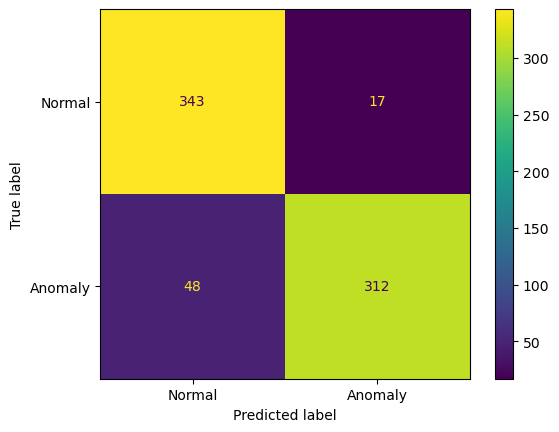

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# 최적의 파라미터
best_params = {
    'max_samples': 0.9936248785777103,
    'contamination': 0.0490777493726473,
    'max_features': 0.8504449128975209
}

model = IsolationForest(
    max_samples=best_params['max_samples'],
    contamination=best_params['contamination'],
    max_features=best_params['max_features'],
    random_state=42
)
model.fit(X_train)

# 테스트 데이터 예측
y_pred = model.predict(X_test)
y_pred = np.where(y_pred == 1, 0, 1)  # 1: 정상 -> 0, -1: 이상 -> 1

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot()

report = classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly'])
print("Classification Report:")
print(report)

# False Positive, False Negative 비율 
false_positive_rate = cm[0, 1] / sum(cm[0])
false_negative_rate = cm[1, 0] / sum(cm[1])

print(f"False Positive Rate: {false_positive_rate:.2f}")
print(f"False Negative Rate: {false_negative_rate:.2f}")


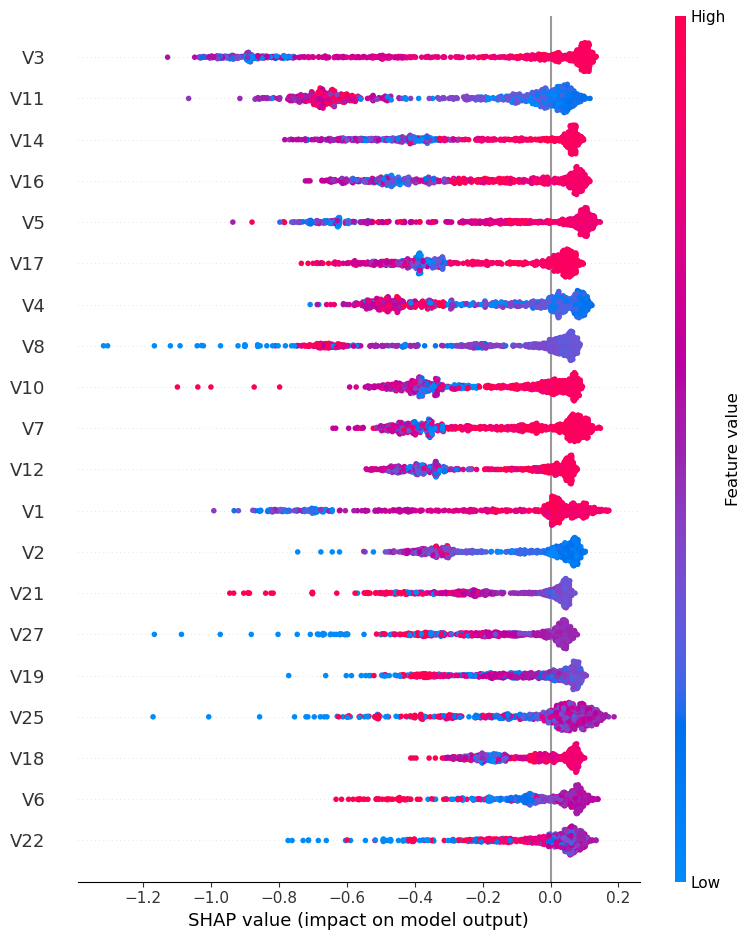

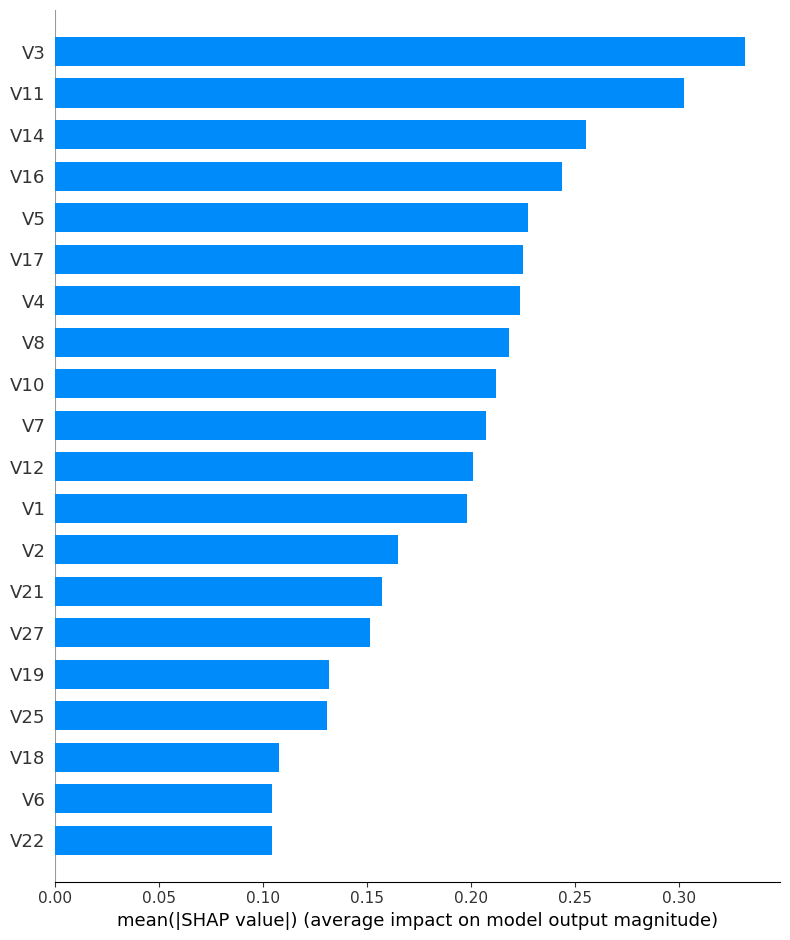

In [ ]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
